This lab on Logistic Regression is a Python adaptation from p. 154-161 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Adapted by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

http://www.science.smith.edu/~jcrouser/SDS293/

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from tqdm import tqdm
import wfdb

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated
print("Hello World")
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

Hello World
---Run time is 0.00011559999998667081 seconds ---



# 4.6.2 Logistic Regression

Let's return to the `Smarket` data from `ISLR`. 

In [2]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list


  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


In [3]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'AppEn', 'SampEn', 'CosEn', 'RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',
       'Rhythm', 'Subject'],
      dtype='object')


In this lab, we will fit a logistic regression model in order to predict `Direction` using `Lag1` through `Lag5` and `Volume`. We'll build our model using the `glm()` function, which is part of the
`formula` submodule of (`statsmodels`).

In [4]:
import statsmodels.formula.api as smf

We can use an `R`-like formula string to separate the predictors from the response.

In [5]:
# formula = 'Direction ~ Lag1+Lag2+Lag3+Lag4+Lag5+Volume'

The `glm()` function fits **generalized linear models**, a class of models that includes logistic regression. The syntax of the `glm()` function is similar to that of `lm()`, except that we must pass in the argument `family=sm.families.Binomial()` in order to tell `python` to run a logistic regression rather than some other type of generalized linear model.

In [6]:
# model_log = smf.glm(formula = formula, data=df, family=sm.families.Binomial())
# result = model_log.fit()
# print(result.summary())

The smallest p-value here is associated with `Lag1`. The negative coefficient
for this predictor suggests that if the market had a positive return yesterday,
then it is less likely to go up today. However, at a value of 0.145, the p-value
is still relatively large, and so there is no clear evidence of a real association
between `Lag1` and `Direction`.

We use the `.params` attribute in order to access just the coefficients for this
fitted model. Similarly, we can use `.pvalues` to get the p-values for the coefficients, and `.model.endog_names` to get the **endogenous** (or dependent) variables.

In [7]:
# print("Coefficeients")
# print(result.params)
# print()
# print("p-Values")
# print(result.pvalues)
# print()
# print("Dependent variables")
# print(result.model.endog_names)

Note that the dependent variable has been converted from nominal into two dummy variables: `['Direction[Down]', 'Direction[Up]']`.

The `predict()` function can be used to predict the probability that the
market will go down, given values of the predictors. If no data set is supplied to the
`predict()` function, then the probabilities are computed for the training
data that was used to fit the logistic regression model. 

In [8]:
# predictions = result.predict()
# print(predictions[0:10])

Here we have printed only the first ten probabilities. Note: these values correspond to the probability of the market going down, rather than up. If we print the model's encoding of the response values alongside the original nominal response, we see that Python has created a dummy variable with a 1 for `Down`.

In [9]:
# print(np.column_stack((df.loc[:,"Direction"], result.model.endog))) # np.vstack or np.hstack
# # exog means x-values; and endog means Y-values

In order to make a prediction as to whether the market will go up or
down on a particular day, we must convert these predicted probabilities
into class labels, `Up` or `Down`. The following *list comprehension* creates a vector
of class predictions based on whether the predicted probability of a market
increase is greater than or less than 0.5.

In [10]:
#

This transforms to `Up` all of the elements for which the predicted probability of a
market increase exceeds 0.5 (i.e. probability of a decrease is below 0.5). Given these predictions, the `confusion\_matrix()` function can be used to produce a confusion matrix in order to determine how many
observations were correctly or incorrectly classified.

#### sklearn.metrics.confusion_matrix

sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
# print(confusion_matrix(df["Direction"], 
#                        predictions_nominal))

The diagonal elements of the confusion matrix indicate correct predictions,
while the off-diagonals represent incorrect predictions. Hence our model
correctly predicted that the market would go up on 507 days and that
it would go down on 145 days, for a total of 507 + 145 = 652 correct
predictions. The `mean()` function can be used to compute the fraction of
days for which the prediction was correct. In this case, logistic regression
correctly predicted the movement of the market 52.2% of the time. this is confirmed by checking the output of the `classification\_report()` function.

#### sklearn.metrics.classification_report

sklearn.metrics.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')

In [12]:
# df["Direction"].value_counts()

In [13]:
# print(classification_report(df["Direction"], 
#                             predictions_nominal, 
#                             digits = 3))

# ##                 Predicted 
# ##                 Down          Up
# ## Truth  Down      145          457
# ##        Up        141          507

# ## For Down: precision = (145)/(145+141) = 0.506993
# ## For Down: recall = (145)/(145+457) = 0.2408638
# ## For Down: f1-score = 2*(precision * recall)/(precision + recall) = 2* (0.507*0.241)/(0.507+0.241)=0.3267032

# ## For Up: precision = (507)/(507+457) = 0.5259336
# ## For Up: recall = (507)/(507+141) = 0.7824074
# ## For Up: f1-score = 2*(precision * recall)/(precision + recall) = 2* (0.526*0.782)/(0.526+0.782)=0.628948

# ## Accuracy = (145+507)/(1250) =0.5216

# ## Macro-average precision = (P1+P2)/2 = (0.507+0.526)/2 = 0.5165
# ## Macro-average recall = (R1+R2)/2 = (0.241+0.782)/2 = 0.5115
# ## Macro-average f1-score = (f1_1+f1_2)/2 = (0.327+0.629)/2 = 0.478


# # Up      648
# # Down    602
# # Total = 1250

# ## Weighted-average precision = w1*P1 + w2*P2 = (602/1250)*0.507 + (648/1250)*0.526 = 0.5168496
# ## Weighted-average recall = w1*R1 + w2*R2 = (602/1250)*0.241 + (648/1250)*0.782 = 0.5214544
# ## Weighted-average f1-score = w1*(f1_1) + w2*(f1_2) = (602/1250)*0.327 + (648/1250)*0.629 = 0.4835568

At first glance, it appears that the logistic regression model is working
a little better than random guessing. But remember, this result is misleading
because we trained and tested the model on the same set of 1,250 observations.
In other words, 100− 52.2 = 47.8% is the **training error rate**. As we
have seen previously, the training error rate is often overly optimistic — it
tends to underestimate the _test_ error rate. 

In order to better assess the accuracy
of the logistic regression model in this setting, we can fit the model
using part of the data, and then examine how well it predicts the held out
data. This will yield a more realistic error rate, in the sense that in practice
we will be interested in our model’s performance not on the data that
we used to fit the model, but rather on days in the future for which the
market’s movements are unknown.

Like we did with KNN, we will first create a vector corresponding
to the observations from 2001 through 2004. We will then use this vector
to create a held out data set of observations from 2005.

In [14]:
# df = pd.read_csv('Data/Smarket.csv', index_col=0, parse_dates=True)
# x_train = df[:'2004'][:]
# y_train = df[:'2004']['Direction']

# x_test = df['2005':][:]
# y_test = df['2005':]['Direction']

We now fit a logistic regression model using only the subset of the observations
that correspond to dates before 2005, using the subset argument.
We then obtain predicted probabilities of the stock market going up for
each of the days in our test set—that is, for the days in 2005.

In [15]:
# model = smf.glm(formula = formula, 
#                 data = x_train, 
#                 family = sm.families.Binomial())
# result = model.fit()
# #print(result.summary())

Notice that we have trained and tested our model on two completely separate
data sets: training was performed using only the dates before 2005,
and testing was performed using only the dates in 2005. Finally, we compute
the predictions for 2005 and compare them to the actual movements
of the market over that time period.

In [16]:
# predictions = result.predict(x_test)
# predictions_nominal = [ "Up" if x < 0.5 else "Down" for x in predictions]
# print(classification_report(y_test, 
#                             predictions_nominal, 
#                             digits = 3))

The results are rather disappointing: the test error
rate (1 - `recall`) is 52%, which is worse than random guessing! Of course this result
is not all that surprising, given that one would not generally expect to be
able to use previous days’ returns to predict future market performance.
(After all, if it were possible to do so, then the authors of this book [along with your professor] would probably
be out striking it rich rather than teaching statistics.)

We recall that the logistic regression model had very underwhelming pvalues
associated with all of the predictors, and that the smallest p-value,
though not very small, corresponded to `Lag1`. Perhaps by removing the
variables that appear not to be helpful in predicting `Direction`, we can
obtain a more effective model. After all, using predictors that have no
relationship with the response tends to cause a deterioration in the test
error rate (since such predictors cause an increase in variance without a
corresponding decrease in bias), and so removing such predictors may in
turn yield an improvement. 

In the space below, refit a logistic regression using just `Lag1` and `Lag2`, which seemed to have the highest predictive power in the original logistic regression model.

In [17]:
# # Write your code to fit the new model here
# formula = 'Direction ~ Lag1+Lag2'
# model = smf.glm(formula = formula, 
#                 data = x_train, 
#                 family = sm.families.Binomial())

# # -----------------------------------
# # This will test your new model; 
# # You don't need to change anything below
# # -----------------------------------
# result = model.fit()
# print(result.summary())
# print()

# predictions = result.predict(x_test)
# predictions_nominal = [ "Up" if x < 0.5 else "Down" for x in predictions]
# print(classification_report(y_test, predictions_nominal, digits = 3))

Now the results appear to be more promising: 56% of the daily movements
have been correctly predicted. The confusion matrix suggests that on days
when logistic regression predicts that the market will decline, it is only
correct 50% of the time. However, on days when it predicts an increase in
the market, it has a 58% accuracy rate.

Finally, suppose that we want to predict the returns associated with **particular
values** of `Lag1` and `Lag2`. In particular, we want to predict Direction on a
day when `Lag1` and `Lag2` equal 1.2 and 1.1, respectively, and on a day when
they equal 1.5 and −0.8. We can do this by passing a new data frame containing our test values to the `predict()` function.

In [18]:
# print(result.predict(pd.DataFrame([[1.2, 1.1], 
#                                    [1.5, -0.8]], 
#                                   columns = ["Lag1","Lag2"])))

To get credit for this lab, play around with a few other values for `Lag1` and `Lag2`, and then post to [#lab4](https://sds293.slack.com/messages/C79BELETC) about what you found. If you're feeling adventurous, try fitting models with other subsets of variables to see if you can find a better one!

### Here is the full code for training/testing

# No CosEn

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, classification_report
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']

from sklearn.inspection import permutation_importance
x_values = ['SampEn','AppEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)

#for df in features_df_list:
#model = DecisionTreeClassifier(max_depth = 6) #criterion='entropy'
df = features_maindf
acc_score = [];
Truth = [];
Output = [];
max_depth_list = []
for idx, subject in tqdm(enumerate(good_list)):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

#     temp_model = DecisionTreeClassifier(max_depth = 6)    
#     param_distributions = {'max_depth': randint(7,9)}

#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     max_depth_list.append(search.best_params_['max_depth'])
    
    model = LogisticRegression(solver= 'liblinear')
    model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

for i in range(0,len(x_values)):
    perm_imp_dict[x_values[i]] = perm_imp_dict[x_values[i]] / 23

perm_imp_dict["log_reg"] = 100
perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)

perm_imp_df_t.to_csv('perm_imp.csv',mode='a',header=False)

perm_imp_df_t = perm_imp_df_t.drop(["log_reg"])


23it [00:06,  3.29it/s]

---Run time is 194.3241273 seconds ---

Accuracy of each fold: 
 [0.9067505720823799, 0.9594320486815415, 0.9937027707808564, 0.7152278177458034, 0.9905956112852664, 0.954158215010142, 0.8187762727697337, 0.9938733832539143, 0.9317269076305221, 0.9608599779492834, 0.9823049001814882, 0.9842067480258435, 0.7129251700680272, 0.9968152866242038, 0.6432139883430474, 0.9353123615418697, 0.9910897875257025, 0.9994229659549914, 0.874894336432798, 0.9796591533809785, 0.9850299401197605, 0.9780288763339611, 0.9788583509513742]

Avg accuracy : 
0.9246463235944995

Std of accuracy : 
0.1008452849507316
[[22773  1970]
 [ 1682 18543]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     24743
           1       0.90      0.92      0.91     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968

[0.9067505720823799, 0.9594320486815415, 0.

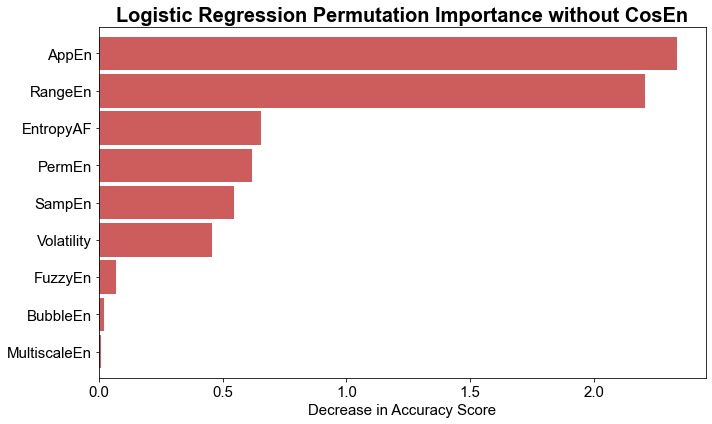

In [15]:
import matplotlib as mpl

df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='indianred', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("Logistic Regression Permutation Importance without CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.xlim(0)
plt.tight_layout()
plt.show()


In [6]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

confusion_matrix1 = pd.DataFrame(confusion_matrix(Truth, Output))
acc_score1 = pd.DataFrame([acc_score])

confusion_matrix1.to_csv("model_results/log_reg_cm.csv",index=False)
acc_score1 = pd.DataFrame([acc_score])
acc_score1 = acc_score1.T
acc_score1.columns = ["Accuracy"]
acc_score1.to_csv("model_results/log_reg_accuracy.csv",index=False)

[[22884  1859]
 [ 1610 18615]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     24743
           1       0.91      0.92      0.91     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968

[0.9078947368421053, 0.9598377281947261, 0.993073047858942, 0.7260191846522782, 0.9879832810867294, 0.9594320486815415, 0.8052312003736571, 0.9945541184479237, 0.9307228915662651, 0.961962513781698, 0.9827586206896551, 0.9849246231155779, 0.7233560090702947, 0.9968152866242038, 0.6848459616985845, 0.9339831634913602, 0.9938313913639479, 0.9994229659549914, 0.8926458157227388, 0.9802089059923035, 0.9867408041060736, 0.9817953546767106, 0.9805496828752642]
62.0635916


# CosEn

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, classification_report
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']

from sklearn.inspection import permutation_importance
x_values = ['CosEn','AppEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)

#for df in features_df_list:
#model = DecisionTreeClassifier(max_depth = 6) #criterion='entropy'
df = features_maindf
acc_score = [];
Truth = [];
Output = [];
max_depth_list = []
for idx, subject in tqdm(enumerate(good_list)):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

#     temp_model = DecisionTreeClassifier(max_depth = 6)    
#     param_distributions = {'max_depth': randint(7,9)}

#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)

#     max_depth_list.append(search.best_params_['max_depth'])
    
    model = LogisticRegression(solver= 'liblinear')
    model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

for i in range(0,len(x_values)):
    perm_imp_dict[x_values[i]] = perm_imp_dict[x_values[i]] / 23


23it [00:07,  2.96it/s]

---Run time is 202.3755982 seconds ---

Accuracy of each fold: 
 [0.9101830663615561, 0.9598377281947261, 0.9937027707808564, 0.7314148681055156, 0.990073145245559, 0.9602434077079107, 0.8080336291452592, 0.9945541184479237, 0.9292168674698795, 0.9586549062844543, 0.9832123411978222, 0.9856424982053122, 0.7256235827664399, 0.9974522292993631, 0.6623646960865945, 0.9264510412051395, 0.9931459904043866, 1.0, 0.8782755705832629, 0.9796591533809785, 0.9850299401197605, 0.9767733835530445, 0.9784355179704017]

Avg accuracy : 
0.9264339327180933

Std of accuracy : 
0.0965383741920882
[[22872  1871]
 [ 1696 18529]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     24743
           1       0.91      0.92      0.91     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968

[0.9101830663615561, 0.9598377281947261, 0.99370277078085

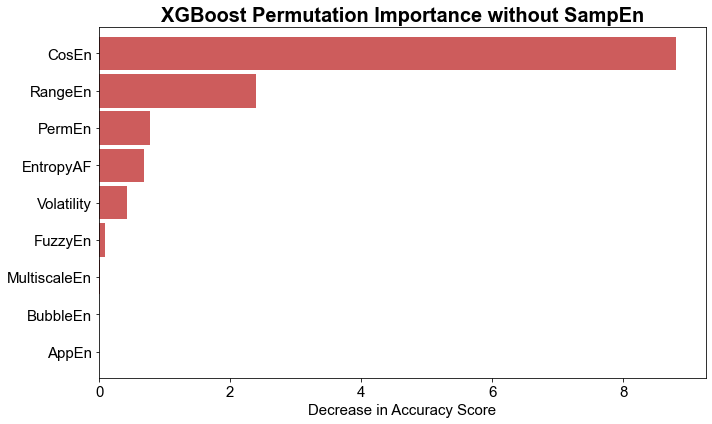

In [17]:
import matplotlib as mpl

perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)


df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='indianred', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("XGBoost Permutation Importance without SampEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.xlim(0)
plt.tight_layout()
plt.show()


# Warining:

Mis-matching may cause bugs in your code. 

If you have y-variable as #’s from your original data, then define “predictions_nominal ” as #s;
 
Otherwise, y-variable as nominal as “High, Low”, “Up/Down” from your original data, then define “predictions_nominal ” as nominal “0” / “1”;

In [20]:
# crossvalidation = KFold(n_splits=5, random_state=2, shuffle=True)
# model = LogisticRegression(solver= 'liblinear')
# scores = cross_val_score(model, X, y, cv=crossvalidation)
# print('Accuracy of each fold: \n {}'.format(scores))
# print()
# print("Avg accuracy: {}".format(scores.mean()))